In [ ]:
from web3 import Web3
from datetime import date, timedelta, datetime, timezone
from dotenv import load_dotenv

import os
import requests
import json 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display

# Load environment variables from .env file
load_dotenv()

ALCHEMY_API_KEY = os.getenv("ALCHEMY_API_KEY")
if not ALCHEMY_API_KEY:
    raise EnvironmentError("ALCHEMY_API_KEY not set in .env file.")

ALCHEMY_URL = f"https://eth-mainnet.g.alchemy.com/v2/{ALCHEMY_API_KEY}"
LIGHTER_ADDRESS = "0x3B4D794a66304F130a4Db8F2551B0070dfCf5ca7" # EVM
USDC_ADDRESS = "0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48" # EVM

# data storage paths
TRANSFER_WITHDRAWALS_FILE_PATH = "data/usdc_transfer_withdrawals.csv"
TRANSFER_DEPOSITS_FILE_PATH = "data/usdc_transfer_deposits.csv"
LOGS_DEPOSITS_FILE_PATH = "data/usdc_logs_deposits.csv"


In [28]:
# Get latest finalized block number
payload = {
    "jsonrpc": "2.0",
    "id": 1,
    "method": "eth_blockNumber",
    "params": ["finalized", False]
}

response = requests.post(ALCHEMY_URL, json=payload).json()
latest_block = int(response["result"], 16)
print(f"Current Ethereum block: {latest_block}")

# Use UTC+8 timezone for all time calculations
utc_plus_8 = timezone(timedelta(hours=8))
current_time = datetime.now(utc_plus_8)
print(f"Current runtime (UTC+8): {current_time.strftime('%Y-%m-%d %H:%M:%S')}")


# https://etherscan.io/tx/0x228496195e6c4a6cdbf9fc3c153cce0fb652e5aeee5a4f0a966b16257ebb34b9
# Lighter contract creation details
DEFAULT_START_BLOCK = 21642011
DEFAULT_START_DATE_STR = "2025-01-17 05:05:35+00:00"  # UTC

# Parse contract creation date as UTC, then convert to UTC+8
default_start_date_utc = datetime.strptime(DEFAULT_START_DATE_STR, "%Y-%m-%d %H:%M:%S%z")
default_start_date_utc8 = default_start_date_utc.astimezone(utc_plus_8)

curr_block = latest_block
days_since_inception = (current_time.date() - default_start_date_utc8.date()).days
blocks_since_inception = curr_block - DEFAULT_START_BLOCK

print(f"Days since contract inception (UTC+8): {days_since_inception}")
print(f"Blocks since contract inception: {blocks_since_inception}")

Current Ethereum block: 23517408
Current runtime (UTC+8): 2025-10-06 16:02:35
Days since contract inception (UTC+8): 262
Blocks since contract inception: 1875397


## Total Value Locked (TVL)

### Contract Balance

The **Total Value Locked (TVL)** represents the USDC balance held by the Lighter contract on Ethereum.

In [30]:
def get_usdc_balance(alchemy_url, contract_address, wallet_address):
    payload = {
        "jsonrpc": "2.0",
        "id": 1,
        "method": "alchemy_getTokenBalances",
        "params": [
            wallet_address,
            [contract_address]
        ]
    }
    resp = requests.post(alchemy_url, json=payload)
    resp.raise_for_status()
    balances = resp.json()["result"]["tokenBalances"]
    if not balances:
        return 0
    return int(balances[0]["tokenBalance"], 16)

usdc_decimals = 6  # USDC always has 6 decimals
usdc_balance = get_usdc_balance(ALCHEMY_URL, USDC_ADDRESS, LIGHTER_ADDRESS) / (10 ** usdc_decimals)
print(f"The current TVL of Lighter: ${usdc_balance:,.2f} USDC")


The current TVL of Lighter: $1,094,964,787.08 USDC


### Transaction Flows

**Analyze contract asset transfers at the transaction level to aggregate `deposits` and `withdrawals` into `daily`, `weekly`, and `monthly` flows.**

* All transfer data is stored in a CSV file to avoid re-querying historical blocks. 
* The CSV will be incrementally updated with batches of processed data.

*Re-running cells will append new data from new blocks to the file!*


In [43]:
# create new csv file
def create_csv(output_file):
    try:
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        with open(output_file, "w") as f:
            pass
        print(f"Created new empty CSV file at {output_file}")
    except Exception as e:
        raise RuntimeError(f"Error creating {output_file}: {e}")

# Determine where to start
def prepare_transfer_blocks(output_file):
    # file already exists, get max block_num
    if os.path.exists(output_file):
        try:
            df_existing = pd.read_csv(output_file)
            start_block = int(df_existing["block_num"].max()) + 1
            print(f"CSV exists! Resuming from block {start_block} (last in CSV + 1)")
            first_batch = False  # Appending to existing file, so no header
        except Exception as e:
            raise RuntimeError(f"Error reading {output_file}: {e}") 
    # doesn't exist, create file and start from default block
    else:
        create_csv(output_file)
        start_block = DEFAULT_START_BLOCK
        first_batch = True # marker for first batch
        print(f"CSV does not exist! Starting from {DEFAULT_START_BLOCK}")
    
    print(
        f"Processing blocks from {start_block} to {curr_block} "
        f"(Number of blocks to process: {curr_block - start_block})"
    )
    return start_block, curr_block, first_batch

In [44]:
# process deposits or withdrawals in batches
def batch_process_transfers(type, output_file, batch_size):
    print(f"Processing {type} in batches of {batch_size}")
    start_block, curr_block, first_batch = prepare_transfer_blocks(output_file)
    all_transfers = []
    batch_num = 0
    for batch_start in range(start_block, curr_block, batch_size):
        batch_end = min(batch_start + batch_size - 1, curr_block)
        print(f"Processing from block {hex(batch_start)} to block {hex(batch_end)}")
        from_block = hex(batch_start)
        to_block = hex(batch_end)
        page_key = None
        batch_transfers = []

        while True:
            payload = {
                "jsonrpc": "2.0",
                "id": 1,
                "method": "alchemy_getAssetTransfers",
                "params": [{
                    "fromBlock": from_block,
                    "toBlock": to_block,
                    "contractAddresses": [USDC_ADDRESS],
                    "category": ["erc20"],
                    "withMetadata": True  # include timestamp in response
                }]
            }

            # set the dynamic payload for deposits and withdrawals
            if type == "deposits":
                payload["params"][0]["toAddress"] = LIGHTER_ADDRESS
            elif type == "withdrawals":
                payload["params"][0]["fromAddress"] = LIGHTER_ADDRESS

            if page_key:
                payload["params"][0]["pageKey"] = page_key

            response = requests.post(ALCHEMY_URL, json=payload).json()
            result = response.get("result", {})
            transfers = result.get("transfers", [])
            batch_transfers.extend(transfers)

            page_key = result.get("pageKey")
            if not page_key:
                break

        print(f"Batch {batch_start} to {batch_end}: {len(batch_transfers)} {type} found")
        all_transfers.extend(batch_transfers)

        # Prepare CSV data for this batch
        csv_data = []
        for tx in batch_transfers:
            csv_data.append({
                "tx_hash": tx["hash"],
                "from": tx["from"],
                "to": tx["to"],
                "amount": float(tx["value"]),
                "block_num": int(tx["blockNum"], 16), # convert hex to int
                "timestamp": pd.to_datetime(tx["metadata"]["blockTimestamp"], utc=True),
            })

        df = pd.DataFrame(csv_data)
        # Save/append to CSV
        if not df.empty:
            df.to_csv(output_file, mode='a', index=False, header=first_batch)
            first_batch = False
        
        batch_num += 1
        # print(f"Processed batch {batch_num}")
    print(f"Found {len(all_transfers)} USDC {type} to {LIGHTER_ADDRESS}")

In [ ]:
# handle deposits
batch_process_transfers(
    type="deposits",
    output_file=TRANSFER_DEPOSITS_FILE_PATH,
    batch_size=100_000
)

Processing deposits in batches of 200000
CSV exists! Resuming from block 23517407 (last in CSV + 1)
Processing blocks from 23517407 to 23517408 (Number of blocks to process: 1)
Processing from block 0x166d8df to block 0x166d8e0
Batch 23517407 to 23517408: 0 deposits found
Found 0 USDC deposits to 0x3B4D794a66304F130a4Db8F2551B0070dfCf5ca7


In [54]:
# handle withdrawals
batch_process_transfers(
    type="withdrawals",
    output_file=TRANSFER_WITHDRAWALS_FILE_PATH,
    batch_size=100_000
)

Processing withdrawals in batches of 100000
CSV exists! Resuming from block 23517383 (last in CSV + 1)
Processing blocks from 23517383 to 23517408 (Number of blocks to process: 25)
Processing from block 0x166d8c7 to block 0x166d8e0
Batch 23517383 to 23517408: 0 withdrawals found
Found 0 USDC withdrawals to 0x3B4D794a66304F130a4Db8F2551B0070dfCf5ca7


In [55]:
# Load deposits
df_transfer_deposits = pd.read_csv(TRANSFER_DEPOSITS_FILE_PATH)
total_transfer_deposits = df_transfer_deposits["amount"].sum()

# Load withdrawals
df_transfer_withdrawals = pd.read_csv(TRANSFER_WITHDRAWALS_FILE_PATH)
total_transfer_withdrawals = df_transfer_withdrawals["amount"].sum()

# Calculate net, should be equal to current balance
net_usdc = total_transfer_deposits - total_transfer_withdrawals

print(f"Total USDC deposited: {total_transfer_deposits:.2f} USDC")
print(f"Total USDC withdrawn: {total_transfer_withdrawals:.2f} USDC")
print(f"Net USDC: {net_usdc:,.2f} USDC")

Total USDC deposited: 2455324003.68 USDC
Total USDC withdrawn: 1360859217.24 USDC
Net USDC: 1,094,464,786.44 USDC



Daily USDC summary (deposits, withdrawals, net, incremental):


,date,total_deposited,total_withdrawn,net_balance,incremental_balance
0,2025-01-17,5.961060e+04,0.000000e+00,5.961060e+04,5.961060e+04
1,2025-01-18,1.038462e+05,0.000000e+00,1.038462e+05,1.634568e+05
2,2025-01-19,8.289817e+03,2.000000e+03,6.289817e+03,1.697466e+05
3,2025-01-20,5.514968e+04,5.000000e+02,5.464968e+04,2.243963e+05
4,2025-01-21,6.287863e+04,0.000000e+00,6.287863e+04,2.872749e+05
...,...,...,...,...,...
258,2025-10-02,1.334564e+08,2.484449e+07,1.086119e+08,8.777964e+08
259,2025-10-03,1.437364e+08,2.677626e+07,1.169601e+08,9.947565e+08
260,2025-10-04,9.420467e+07,3.540174e+07,5.880293e+07,1.053559e+09
261,2025-10-05,6.137218e+07,2.925850e+07,3.211369e+07,1.085673e+09


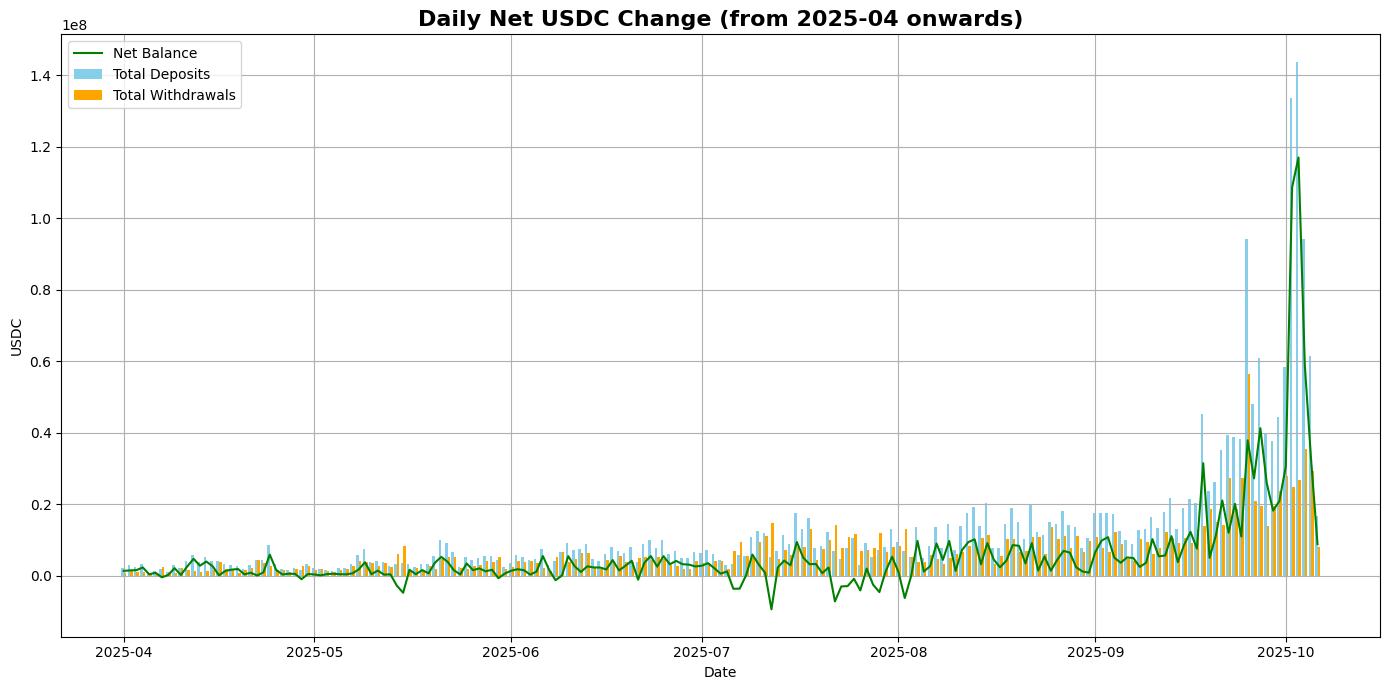

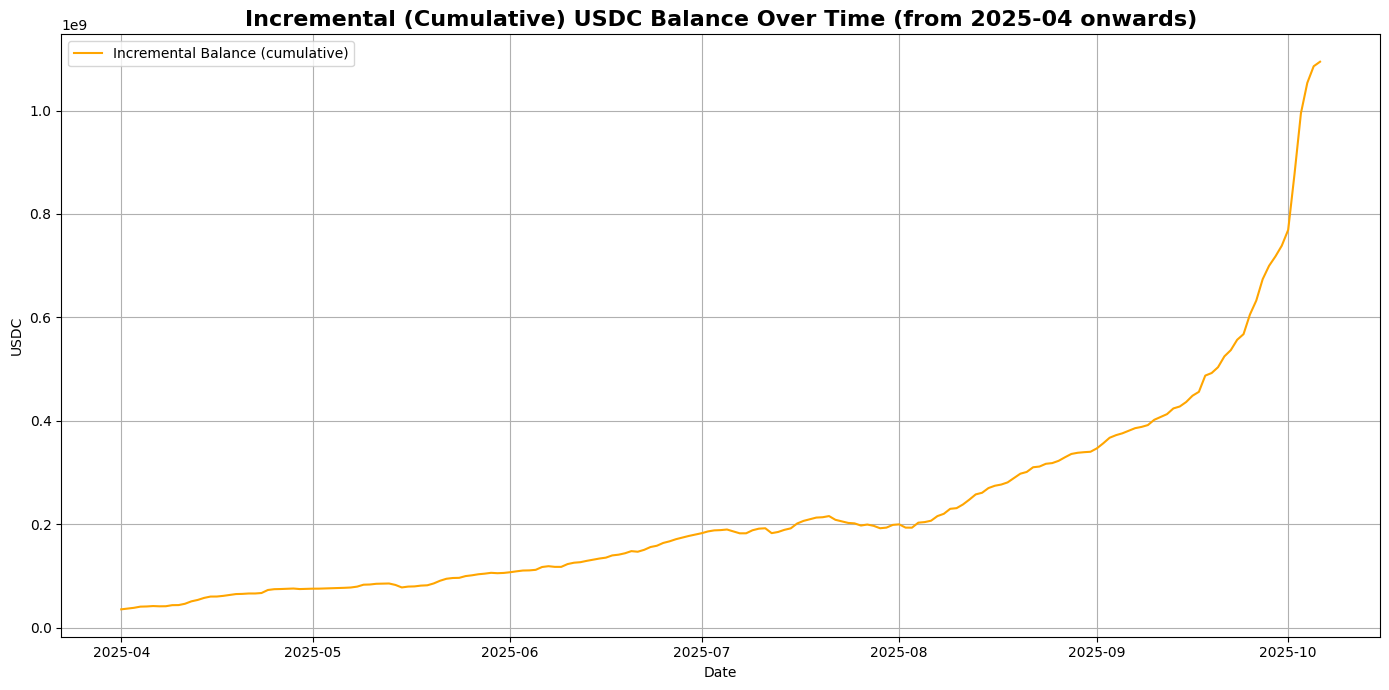

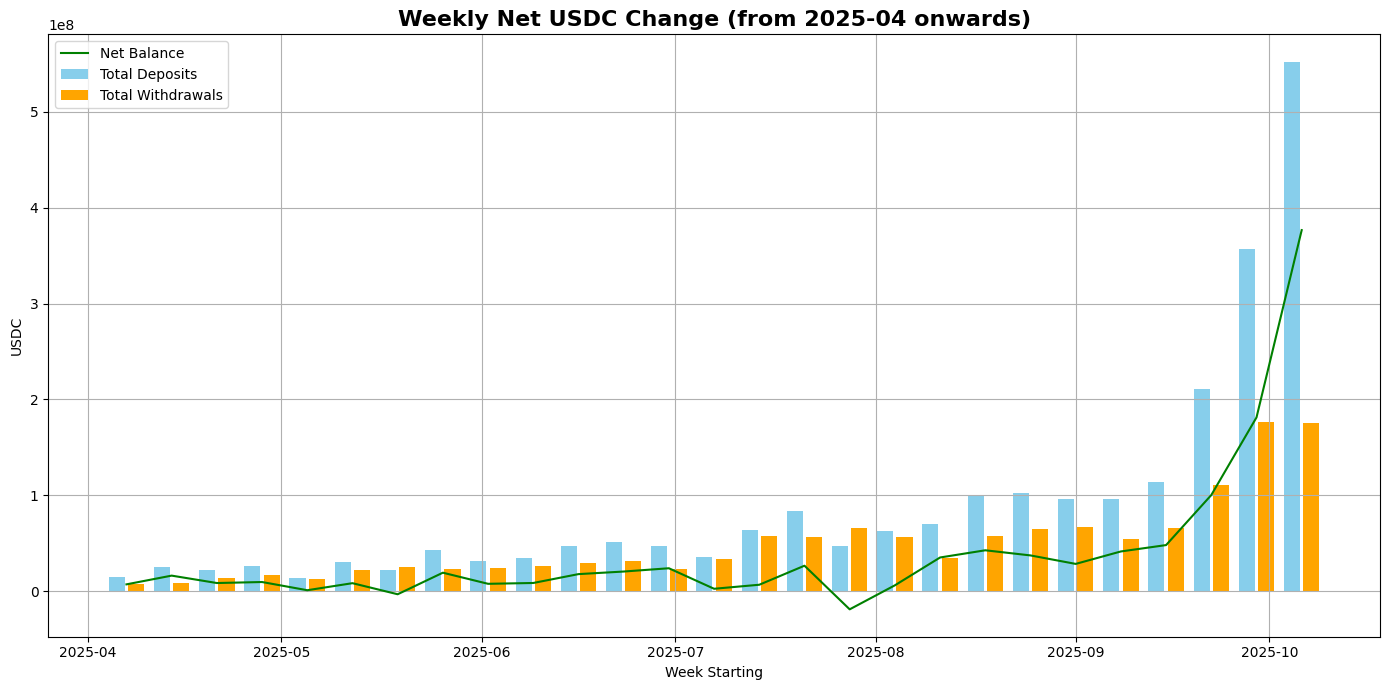

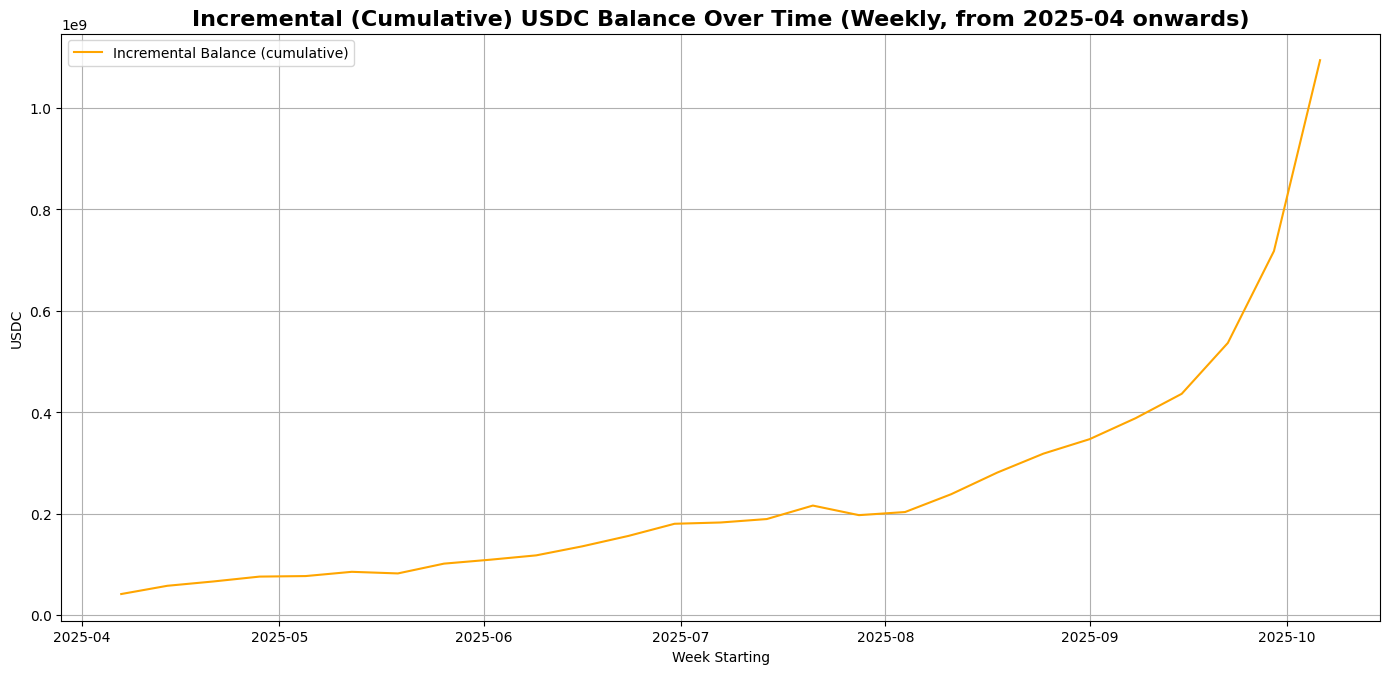

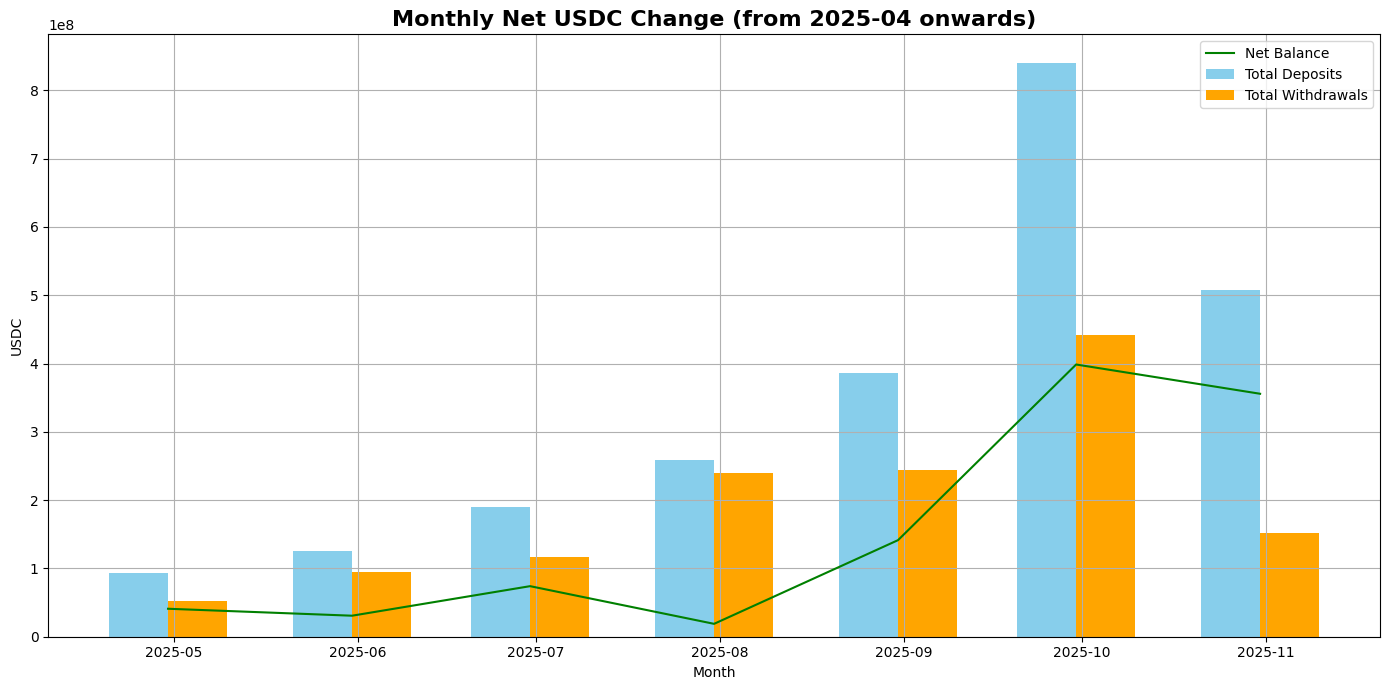

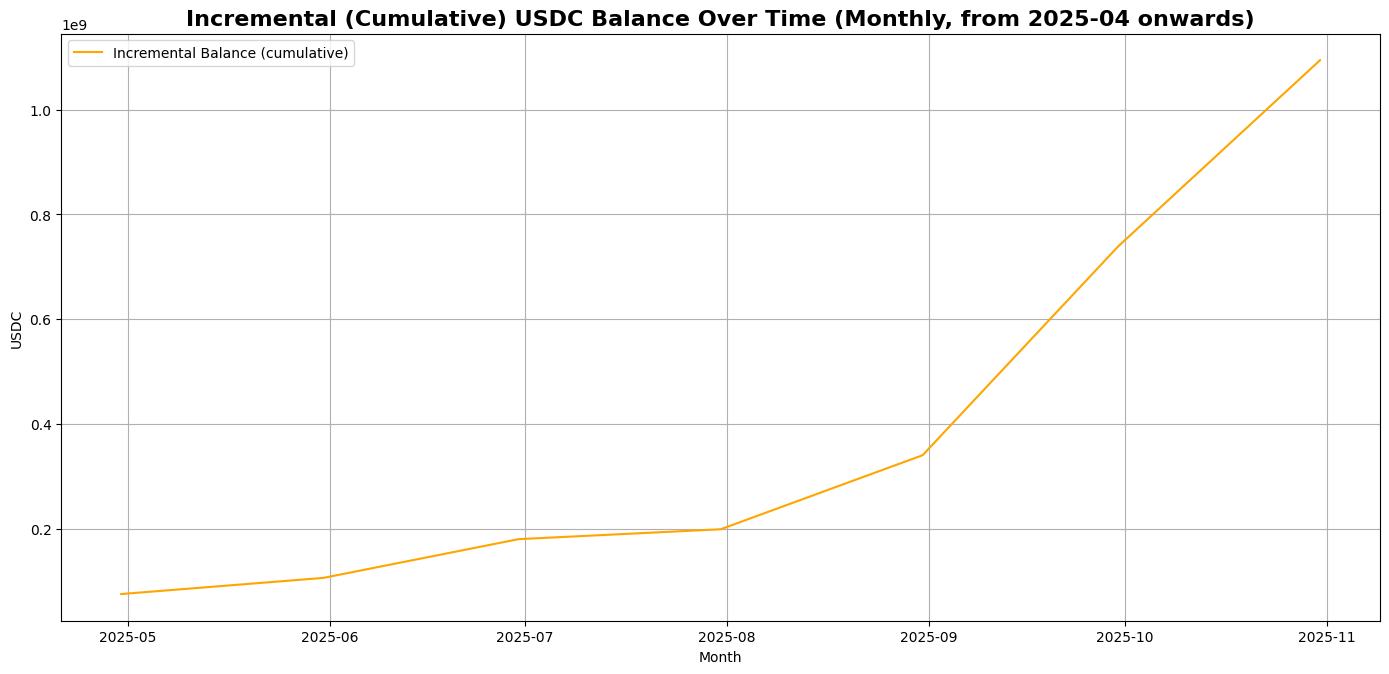

In [66]:
# Group by day for deposits and withdrawals, aggregate total_deposited, total_withdrawn, net_balance, and incremental balance

# Ensure date columns exist
df_transfer_deposits['date'] = pd.to_datetime(df_transfer_deposits['timestamp']).dt.date
df_transfer_withdrawals['date'] = pd.to_datetime(df_transfer_withdrawals['timestamp']).dt.date

# Aggregate total deposits by date
deposits_by_day = df_transfer_deposits.groupby('date').agg(
    total_deposited=('amount', 'sum')
).reset_index()

# Aggregate total withdrawals by date
withdrawals_by_day = df_transfer_withdrawals.groupby('date').agg(
    total_withdrawn=('amount', 'sum')
).reset_index()

# Merge on date to get both deposits and withdrawals per day
daily_summary = pd.merge(
    deposits_by_day,
    withdrawals_by_day,
    on='date',
    how='outer'
).fillna(0)

# Calculate net balance per day
daily_summary['net_balance'] = daily_summary['total_deposited'] - daily_summary['total_withdrawn']

# Sort by date
daily_summary = daily_summary.sort_values('date').reset_index(drop=True)

# Calculate incremental (cumulative) balance over time
daily_summary['incremental_balance'] = daily_summary['net_balance'].cumsum()

print("\nDaily USDC summary (deposits, withdrawals, net, incremental):")
display(daily_summary)

# Filter data to only include dates from 2025-04 onwards
start_date = pd.to_datetime("2025-04-01").date()
filtered_summary = daily_summary[daily_summary['date'] >= start_date]

# --- DAILY PLOTS ---
plt.figure(figsize=(14, 7))
bar_width = 0.4
dates = pd.to_datetime(filtered_summary['date'])

plt.bar(dates - pd.Timedelta(days=0.2), filtered_summary['total_deposited'], 
        width=bar_width, label='Total Deposits', align='center', color='skyblue')
plt.bar(dates + pd.Timedelta(days=0.2), filtered_summary['total_withdrawn'], 
        width=bar_width, label='Total Withdrawals', align='center', color='orange')
plt.plot(dates, filtered_summary['net_balance'], linestyle='-', color='green', label='Net Balance')

plt.xlabel('Date')
plt.ylabel('USDC')
plt.title("Daily Net USDC Change (from 2025-04 onwards)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(filtered_summary['date'], filtered_summary['incremental_balance'], linestyle='-', color='orange', label='Incremental Balance (cumulative)')
plt.xlabel('Date')
plt.ylabel('USDC')
plt.title("Incremental (Cumulative) USDC Balance Over Time (from 2025-04 onwards)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.show()

# --- WEEKLY PLOTS ---
# Convert 'date' to datetime for resampling
daily_summary['date'] = pd.to_datetime(daily_summary['date'])
weekly_summary = daily_summary.set_index('date').resample('W-MON').agg({
    'total_deposited': 'sum',
    'total_withdrawn': 'sum',
    'net_balance': 'sum'
}).reset_index()
weekly_summary['incremental_balance'] = weekly_summary['net_balance'].cumsum()

filtered_weekly = weekly_summary[weekly_summary['date'] >= pd.to_datetime(start_date)]

plt.figure(figsize=(14, 7))
bar_width = 2.5  # weeks are longer, so wider bars
dates = filtered_weekly['date']

plt.bar(dates - pd.Timedelta(days=1.5), filtered_weekly['total_deposited'], 
        width=bar_width, label='Total Deposits', align='center', color='skyblue')
plt.bar(dates + pd.Timedelta(days=1.5), filtered_weekly['total_withdrawn'], 
        width=bar_width, label='Total Withdrawals', align='center', color='orange')
plt.plot(dates, filtered_weekly['net_balance'], linestyle='-', color='green', label='Net Balance')

plt.xlabel('Week Starting')
plt.ylabel('USDC')
plt.title("Weekly Net USDC Change (from 2025-04 onwards)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(filtered_weekly['date'], filtered_weekly['incremental_balance'], linestyle='-', color='orange', label='Incremental Balance (cumulative)')
plt.xlabel('Week Starting')
plt.ylabel('USDC')
plt.title("Incremental (Cumulative) USDC Balance Over Time (Weekly, from 2025-04 onwards)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.show()

# --- MONTHLY PLOTS ---
monthly_summary = daily_summary.set_index('date').resample('ME').agg({
    'total_deposited': 'sum',
    'total_withdrawn': 'sum',
    'net_balance': 'sum'
}).reset_index()
monthly_summary['incremental_balance'] = monthly_summary['net_balance'].cumsum()

filtered_monthly = monthly_summary[monthly_summary['date'] >= pd.to_datetime(start_date)]

plt.figure(figsize=(14, 7))
bar_width = 10  # months are even longer, so wider bars
dates = filtered_monthly['date']

plt.bar(dates - pd.Timedelta(days=5), filtered_monthly['total_deposited'], 
        width=bar_width, label='Total Deposits', align='center', color='skyblue')
plt.bar(dates + pd.Timedelta(days=5), filtered_monthly['total_withdrawn'], 
        width=bar_width, label='Total Withdrawals', align='center', color='orange')
plt.plot(dates, filtered_monthly['net_balance'], linestyle='-', color='green', label='Net Balance')

plt.xlabel('Month')
plt.ylabel('USDC')
plt.title("Monthly Net USDC Change (from 2025-04 onwards)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(filtered_monthly['date'], filtered_monthly['incremental_balance'], linestyle='-', color='orange', label='Incremental Balance (cumulative)')
plt.xlabel('Month')
plt.ylabel('USDC')
plt.title("Incremental (Cumulative) USDC Balance Over Time (Monthly, from 2025-04 onwards)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.grid(True)
plt.legend()
plt.show()

## User Wallet Segmentation

To analyze wallet holders and their key metrics, on-chain deposit and withdrawal information is obtained for wallet segmentation.
Lighter supports Ethereum Layer 1 transactions and other EVM-compatible chains (Arbitrum, Base, Avalanche, etc.).

Note:
* If a user transacts on Arbitrum, there will not be an Ethereum transaction (and vice versa).
* Arbitrum transactions are later posted to Ethereum as a new transaction.


### Deposits into Lighter (IN)

**On Ethereum (L1):**
* Transaction created on Ethereum.
* USDC contract emits `Transfer` event (from user → Lighter address).
* Lighter contract emits `Deposit` event.

**On other chains (example: Arbitrum):**
* Transaction created on Arbitrum.
* USDC contract emits `Transfer` event (from user → USDC bridge address).
* Multiple L2 transactions are batched to Ethereum. For each L2 transfer, Lighter contract emits `Deposit` event.
* This mints USDC (balance increases in Lighter).

**Retrieving unique wallet deposits:**
* Logs of batch deposits can be inspected to get all deposit information.
* `Deposit` event includes:
  * `toAccountIndex`
  * `toAddress`
  * `amount`


### Withdrawals from Lighter (OUT)

**On Ethereum (L1):**
* Transaction created on Ethereum.
* USDC contract emits `Transfer` event (from Lighter → user).
* Lighter contract emits `WithdrawPending` event.

**On other chains (example: Arbitrum):**
* Transaction created on Arbitrum.
* USDC contract emits `Transfer` event (from bridge address → user).
* Withdrawal goes through proxy address: `0x3fbba2b0e07895ae8638d17fd83d72338954d272`.
* This burns USDC (balance decreases in Lighter).
* Unique withdrawal info cannot be fully retrieved via logs.


### Key Contracts
* zkLighter (Ethereum): `0x3b4d794a66304f130a4db8f2551b0070dfcf5ca7`
* Circle USDC (Ethereum): `0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48`
* Circle USDC (Arbitrum): `0xaf88d065e77c8cc2239327c5edb3a432268e5831`

### Event Logs

In [68]:
# this is the topic for USDC deposits to LIGHTER_ADDRESS
DEPOSIT_TOPIC = "0x15dce32b28da4e9abe948d3acb53e6764159ef75b454aa1030604232a8d366bb"

def process_log_data(log):
    try:
        # The 'data' field is a hex string containing the event parameters, packed as 32-byte words.
        data = log["data"]
        # Remove '0x' prefix and split into 32-byte (64 hex chars) chunks
        data_words = [data[i : i + 64] for i in range(2, len(data), 64)]
        # The Lighter Deposit event has: toAccountIndex (1st), toAddress (2nd), amount (3rd)
        # toAddress is the 2nd word (index 1), last 40 hex chars (20 bytes)
        to_address_hex = data_words[1][-40:]
        wallet = "0x" + to_address_hex.lower()
        # amount is the 3rd word (index 2)
        amount = int(data_words[2], 16) / 1e6  # USDC has 6 decimals
        return {
            "wallet": wallet,
            "amount": amount,
            # "block_hash": log["blockHash"],
            "block_num": int(log["blockNumber"], 16),
            "tx_hash": log["transactionHash"],
            "timestamp": pd.to_datetime(
                int(log["blockTimestamp"], 16), unit="s", utc=True
            ),
        }
    except Exception as e:
        print(log)
        print(f"Error processing log: {e}")
        return None

def batch_process_logs(type, output_file, batch_size):
    print(f"Processing logs in batches of {batch_size}")
    start_block, curr_block, first_batch = prepare_transfer_blocks(output_file)
    all_transfers = []
    batch_num = 0
    print(
        "start_block:",
        start_block,
        "curr_block:",
        curr_block,
        "first_batch:",
        first_batch,
    )

    for batch_start in range(start_block, curr_block, batch_size):
        batch_end = min(batch_start + batch_size - 1, curr_block)
        print(f"Processing from block {hex(batch_start)} to block {hex(batch_end)}")
        from_block = hex(batch_start)
        to_block = hex(batch_end)
        # page_key = None
        batch_data = []

        # while True:
        payload = {
            "jsonrpc": "2.0",
            "id": 1,
            "method": "eth_getLogs",
            "params": [
                {
                    "fromBlock": from_block,
                    "toBlock": to_block,
                    "address": LIGHTER_ADDRESS,  # contract emitting the logs
                    "topics": [DEPOSIT_TOPIC],
                }
            ],
        }

        response = requests.post(ALCHEMY_URL, json=payload).json()
        # print(json.dumps(response, indent=4))
        result = response.get("result", {})
        # data = result.get("data", [])
        batch_data.extend(result)

        print(f"Batch {batch_start} to {batch_end}: {len(batch_data)} {type} found")
        all_transfers.extend(batch_data)

        # Prepare CSV data for this batch
        csv_data = []
        for tx in batch_data:
            tx = process_log_data(tx)
            csv_data.append(
                {
                    "wallet": tx["wallet"],
                    "amount": tx["amount"],
                    # "block_hash": tx["block_hash"],
                    "block_num": tx["block_num"],
                    "tx_hash": tx["tx_hash"],
                    "timestamp": tx["timestamp"],
                }
            )

        df = pd.DataFrame(csv_data)
        # Save/append to CSV
        if not df.empty:
            df.to_csv(output_file, mode="a", index=False, header=first_batch)
            first_batch = False

        batch_num += 1
        # print(f"Processed batch {batch_num}")
    print(f"Found {len(all_transfers)} logs (USDC {type}) to {LIGHTER_ADDRESS}")

In [69]:
# handle deposits
batch_process_logs(
    type="deposits",
    output_file="data/usdc_logs_deposits.csv",
    batch_size=10_000 # pay-as-you-go plan, free plan only allows 10 blocks per batch.
)

Processing logs in batches of 10000
CSV exists! Resuming from block 23508559 (last in CSV + 1)
Processing blocks from 23508559 to 23517408 (Number of blocks to process: 8849)
start_block: 23508559 curr_block: 23517408 first_batch: False
Processing from block 0x166b64f to block 0x166d8e0
Batch 23508559 to 23517408: 12357 deposits found
Found 12357 logs (USDC deposits) to 0x3B4D794a66304F130a4Db8F2551B0070dfCf5ca7


In [70]:
# Compare total deposit amounts to check accuracy of logs
df_log_deposits = pd.read_csv(LOGS_DEPOSITS_FILE_PATH)
df_transfer_deposits = pd.read_csv(TRANSFER_DEPOSITS_FILE_PATH)

total_deposit_transfers = df_transfer_deposits["amount"].sum()
total_deposit_logs = df_log_deposits["amount"].sum()

print(f"Total deposit amount (transfers): {total_deposit_transfers}")
print(f"Total deposit amount (logs): {total_deposit_logs}")
print(f"Difference: {total_deposit_transfers - total_deposit_logs}")


Total deposit amount (transfers): 2455324003.6805716
Total deposit amount (logs): 2455323983.5596404
Difference: 20.120931148529053


### Data Processing

In [71]:
# Group by unique users (wallets), summing their total deposits
user_deposit_totals = df_log_deposits.groupby("wallet")["amount"].sum().reset_index()
user_deposit_totals = user_deposit_totals.rename(columns={"amount": "sum_deposits"})

# Count number of deposits per wallet
wallet_deposit_counts = df_log_deposits.groupby("wallet")["amount"].count().reset_index()
wallet_deposit_counts = wallet_deposit_counts.rename(columns={"amount": "num_deposits"})

# Merge deposit totals and counts 
user_deposit_stats = user_deposit_totals.merge(wallet_deposit_counts, on="wallet")
display(user_deposit_stats)

# Key metrics
num_unique_users = user_deposit_stats["wallet"].nunique()
total_deposit_sum = user_deposit_stats["sum_deposits"].sum()
mean_deposit = user_deposit_stats["sum_deposits"].mean()
median_deposit = user_deposit_stats["sum_deposits"].median()
max_deposit = user_deposit_stats["sum_deposits"].max()
min_deposit = user_deposit_stats["sum_deposits"].min()

print(f"Number of unique depositors: {num_unique_users}")
print(f"Total deposited (all users): {total_deposit_sum:,.2f}")
print(f"Mean deposit per user: {mean_deposit:,.2f}")
print(f"Median deposit per user: {median_deposit:,.2f}")

# Group users by deposit size (binning)
deposit_size_bins = [0, 50, 100, 500, 1_000, 5_000, 10_000, 50_000, 100_000, 500_000, 1_000_000, float("inf")]
deposit_size_labels = [
    "<$50", "$50-100", "$100-500", "$500-1k", "$1k-5k", "$5k-10k", "$10k-50k", "$50k-100k", "$100k-500k", "$500k-1M", ">$1M"
]
user_deposit_stats["deposit_size_group"] = pd.cut(
    user_deposit_stats["sum_deposits"], bins=deposit_size_bins, labels=deposit_size_labels, right=False
)
deposit_sum_grouped = (
    user_deposit_stats
    .groupby("deposit_size_group", observed=True)
    .agg(
        num_users=("wallet", "count"),
        total_deposit_sum=("sum_deposits", "sum"),
        avg_deposit_per_user=("sum_deposits", "mean"),
        median_deposit_per_user=("sum_deposits", "median"),
    )
    .reset_index()
)

print("\nStats by deposit size group:")
display(deposit_sum_grouped)

# Bin number of deposits per wallet with finer granularity
deposit_count_bins = [1, 2, 3, 4, 5, 6, 10, 25, 50, 100, float("inf")]
deposit_count_labels = [
    "1", "2", "3", "4", "5", "6-9", "10-24", "25-49", "50-99", "100+"
]
user_deposit_stats["num_deposits_group"] = pd.cut(
    user_deposit_stats["num_deposits"], bins=deposit_count_bins, labels=deposit_count_labels, right=False
)

deposit_count_grouped = (
    user_deposit_stats
    .groupby("num_deposits_group", observed=True)
    .agg(
        num_users=("wallet", "count"),
        total_deposit_sum=("sum_deposits", "sum"),
        avg_deposit_per_user=("sum_deposits", "mean"),
        median_deposit_per_user=("sum_deposits", "median")
    )
    .reset_index()
)

print("\nStats by deposit counts group:")
display(deposit_count_grouped)


,wallet,sum_deposits,num_deposits
0,0x0000000000000000000000000000000000000000,1000.000000,1
1,0x000000000000134c41930c0a6324efd7e8d4a3bb,2415.480000,4
2,0x00000000000a78c8727b6ae386f004e7e37a4875,1638.538892,4
3,0x00000000051cbce3fd04148cce2c0adc7c651829,32.700000,1
4,0x000000003f7d689a6887363c60b9ddbe78704d4c,105.000000,1
...,...,...,...
215566,0xffff59975054ab6d367ab3070547a203b0a565f7,592.790000,1
215567,0xffffd39678c072b55f08d15d2728d9b65ad5d050,531.000000,2
215568,0xffffd44e65b608548191073ad220866d51f5748e,337.090000,3
215569,0xffffe979aac42b9ce7eb29fcdf0c5b1bff14a038,198.990000,1


Number of unique depositors: 215571
Total deposited (all users): 2,455,323,983.56
Mean deposit per user: 11,389.86
Median deposit per user: 207.69

Stats by deposit size group:


,deposit_size_group,num_users,total_deposit_sum,avg_deposit_per_user,median_deposit_per_user
0,<$50,35088,7.336171e+05,2.090792e+01,19.990
1,$50-100,32841,2.561164e+06,7.798677e+01,79.710
2,$100-500,72739,1.690470e+07,2.324022e+02,199.990
3,$500-1k,26862,1.700900e+07,6.331993e+02,537.780
4,$1k-5k,26642,5.474632e+07,2.054888e+03,1636.340
5,$5k-10k,8088,5.378606e+07,6.650107e+03,6068.720
6,$10k-50k,8236,1.806363e+08,2.193252e+04,19238.805
7,$50k-100k,1965,1.363591e+08,6.939393e+04,66131.890
8,$100k-500k,2352,4.930641e+08,2.096361e+05,175618.280
9,$500k-1M,399,2.822466e+08,7.073850e+05,684503.850



Stats by deposit counts group:


,num_deposits_group,num_users,total_deposit_sum,avg_deposit_per_user,median_deposit_per_user
0,1,145494,1.914193e+08,1.315651e+03,157.130427
1,2,32939,1.933115e+08,5.868774e+03,310.790000
2,3,12074,1.552575e+08,1.285883e+04,995.325592
3,4,6578,1.193735e+08,1.814738e+04,1379.256181
4,5,4212,1.085632e+08,2.577473e+04,2545.689412
5,6-9,9036,4.413384e+08,4.884224e+04,5551.680000
6,10-24,4246,5.559733e+08,1.309405e+05,10497.915000
7,25-49,755,4.031098e+08,5.339202e+05,29963.564575
8,50-99,181,1.104839e+08,6.104081e+05,85688.600000
9,100+,56,1.764937e+08,3.151673e+06,264510.010000


### Plots

,deposit_size_group,num_users,total_deposit_sum,avg_deposit_per_user,median_deposit_per_user
0,<$50,35088,7.336171e+05,2.090792e+01,19.990
1,$50-100,32841,2.561164e+06,7.798677e+01,79.710
2,$100-500,72739,1.690470e+07,2.324022e+02,199.990
3,$500-1k,26862,1.700900e+07,6.331993e+02,537.780
4,$1k-5k,26642,5.474632e+07,2.054888e+03,1636.340
5,$5k-10k,8088,5.378606e+07,6.650107e+03,6068.720
6,$10k-50k,8236,1.806363e+08,2.193252e+04,19238.805
7,$50k-100k,1965,1.363591e+08,6.939393e+04,66131.890
8,$100k-500k,2352,4.930641e+08,2.096361e+05,175618.280
9,$500k-1M,399,2.822466e+08,7.073850e+05,684503.850


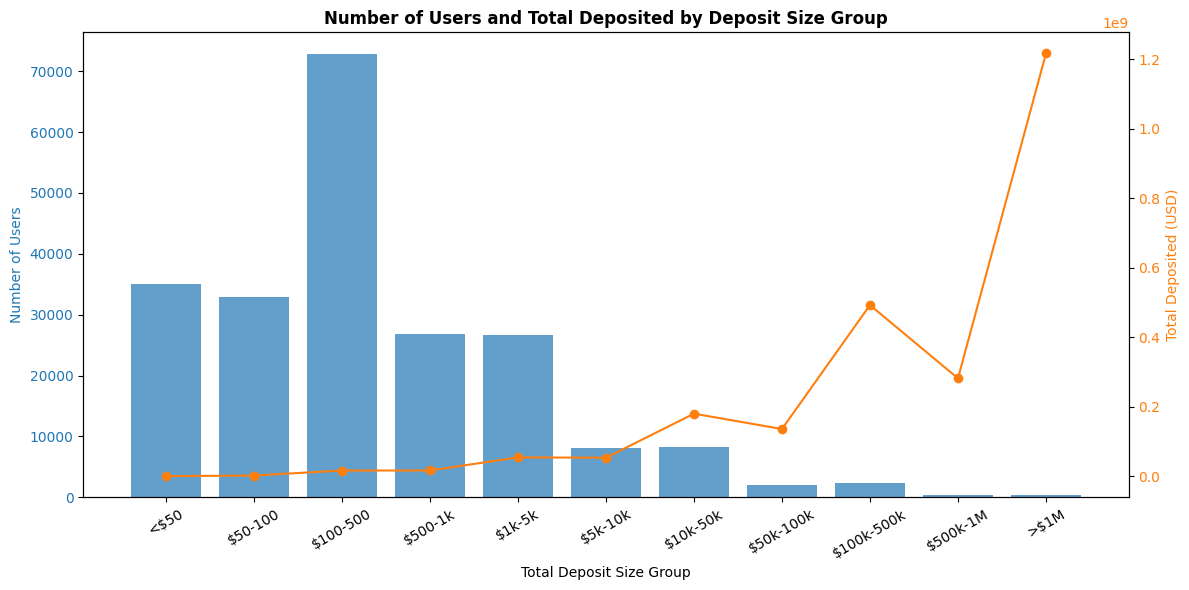

,num_deposits_group,num_users,total_deposit_sum,avg_deposit_per_user,median_deposit_per_user
0,1,145494,1.914193e+08,1.315651e+03,157.130427
1,2,32939,1.933115e+08,5.868774e+03,310.790000
2,3,12074,1.552575e+08,1.285883e+04,995.325592
3,4,6578,1.193735e+08,1.814738e+04,1379.256181
4,5,4212,1.085632e+08,2.577473e+04,2545.689412
5,6-9,9036,4.413384e+08,4.884224e+04,5551.680000
6,10-24,4246,5.559733e+08,1.309405e+05,10497.915000
7,25-49,755,4.031098e+08,5.339202e+05,29963.564575
8,50-99,181,1.104839e+08,6.104081e+05,85688.600000
9,100+,56,1.764937e+08,3.151673e+06,264510.010000


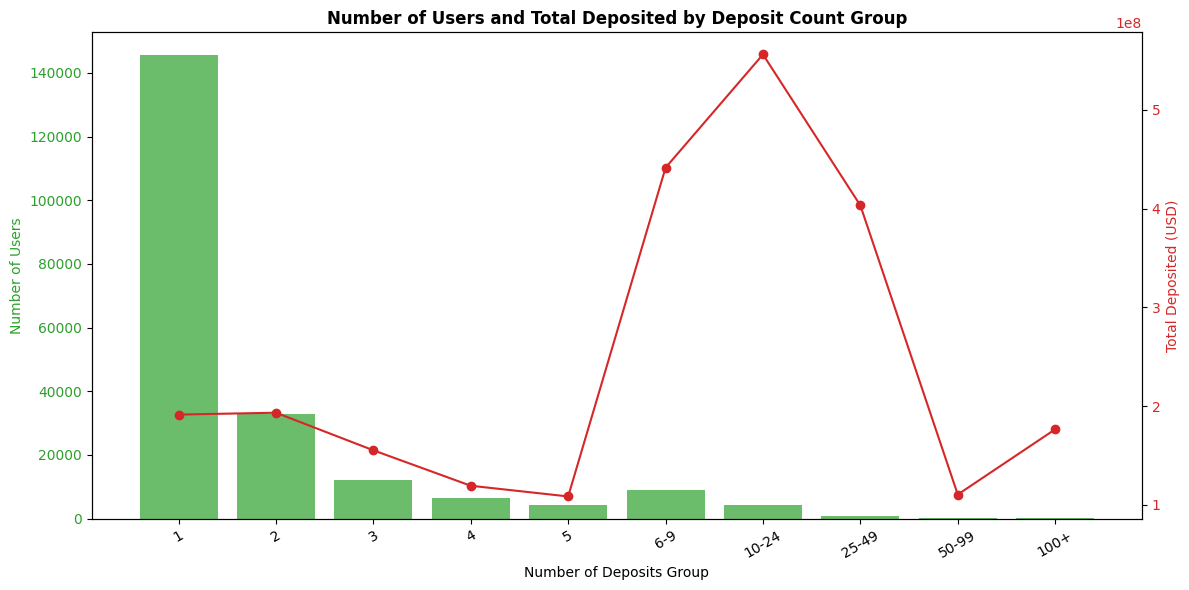

In [72]:
def plot_deposit_size_group_stats(deposit_sum_grouped):
    try:
        fig, ax1 = plt.subplots(figsize=(12, 6))

        color_users = 'tab:blue'
        color_deposit = 'tab:orange'

        x_labels = deposit_sum_grouped["deposit_size_group"].astype(str)
        x = range(len(x_labels))

        # Bar plot for number of users
        ax1.bar(x, deposit_sum_grouped["num_users"], color=color_users, alpha=0.7, label="Number of Users")
        ax1.set_xlabel("Total Deposit Size Group")
        ax1.set_ylabel("Number of Users", color=color_users)
        ax1.tick_params(axis='y', labelcolor=color_users)
        ax1.set_xticks(x)
        ax1.set_xticklabels(x_labels, rotation=30)

        # Line plot for total deposited
        ax2 = ax1.twinx()
        ax2.plot(x, deposit_sum_grouped["total_deposit_sum"], color=color_deposit, marker='o', label="Total Deposited")
        ax2.set_ylabel("Total Deposited (USD)", color=color_deposit)
        ax2.tick_params(axis='y', labelcolor=color_deposit)

        plt.title("Number of Users and Total Deposited by Deposit Size Group", fontweight='bold')
        fig.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting deposit size group stats: {e}")

def plot_deposit_count_group_stats(deposit_count_grouped):
    try:
        fig, ax1 = plt.subplots(figsize=(12, 6))

        color_users = 'tab:green'
        color_deposit = 'tab:red'

        x_labels = deposit_count_grouped["num_deposits_group"].astype(str)
        x = range(len(x_labels))

        # Bar plot for number of users
        ax1.bar(x, deposit_count_grouped["num_users"], color=color_users, alpha=0.7, label="Number of Users")
        ax1.set_xlabel("Number of Deposits Group")
        ax1.set_ylabel("Number of Users", color=color_users)
        ax1.tick_params(axis='y', labelcolor=color_users)
        ax1.set_xticks(x)
        ax1.set_xticklabels(x_labels, rotation=30)

        # Line plot for total deposited
        ax2 = ax1.twinx()
        ax2.plot(x, deposit_count_grouped["total_deposit_sum"], color=color_deposit, marker='o', label="Total Deposited")
        ax2.set_ylabel("Total Deposited (USD)", color=color_deposit)
        ax2.tick_params(axis='y', labelcolor=color_deposit)

        plt.title("Number of Users and Total Deposited by Deposit Count Group", fontweight='bold')
        fig.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error plotting deposit count group stats: {e}")

# Call plotting functions
display(deposit_sum_grouped)
plot_deposit_size_group_stats(deposit_sum_grouped)

display(deposit_count_grouped)
plot_deposit_count_group_stats(deposit_count_grouped)


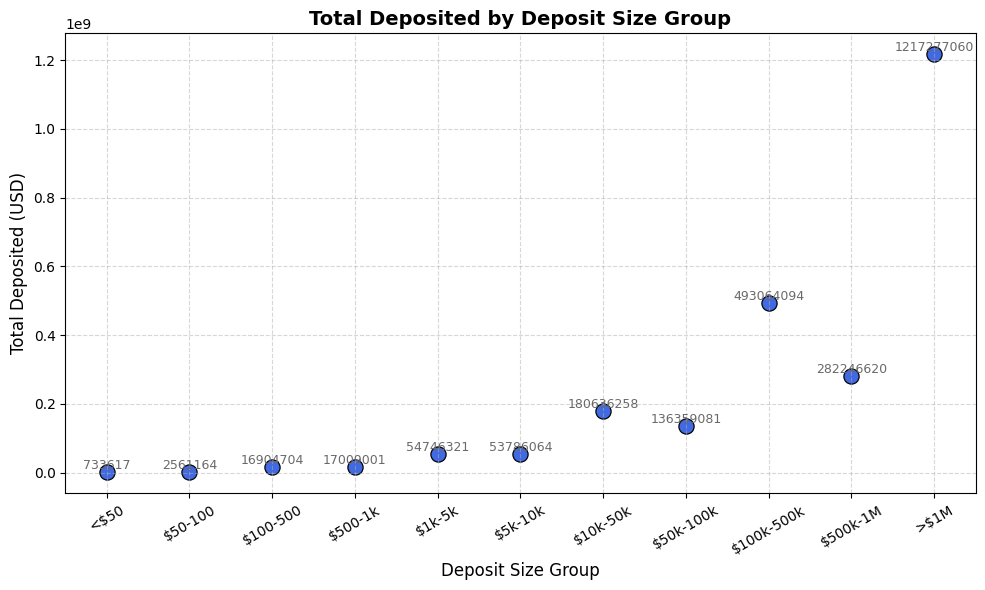

In [73]:
# Enhanced scatter plot for deposit size group vs total deposited
fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(
    x="deposit_size_group",
    y="total_deposit_sum",
    data=deposit_sum_grouped,
    s=120,
    color="royalblue",
    edgecolor="black",
    ax=ax
)
ax.set_xlabel("Deposit Size Group", fontsize=12)
ax.set_ylabel("Total Deposited (USD)", fontsize=12)
ax.set_title("Total Deposited by Deposit Size Group", fontsize=14, fontweight='bold')
ax.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=30)
for i, row in deposit_sum_grouped.iterrows():
    ax.text(
        i, row["total_deposit_sum"], 
        f'{row["total_deposit_sum"]:.0f}', 
        ha='center', va='bottom', fontsize=9, color='dimgray'
    )
plt.tight_layout()
plt.show()
